In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn joblib


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib


In [ ]:
df = pd.read_csv('/content/tmdb_5000_movies.csv')
df.head()


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [ ]:
import ast

# Keep relevant columns
cols = ['budget','revenue','genres','popularity','runtime','vote_average','vote_count','release_date','original_language']
df = df[cols].copy()

# Convert data types
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Remove missing or invalid rows
df = df.dropna(subset=['budget','revenue','release_date'])
df = df[(df['budget'] > 0) & (df['revenue'] > 0)]

# Extract year
df['year'] = df['release_date'].dt.year

# Extract primary genre
def get_genre(x):
    try:
        genres = ast.literal_eval(x)
        if len(genres) > 0:
            return genres[0]['name']
    except:
        return np.nan
df['genre'] = df['genres'].apply(get_genre)
df = df.dropna(subset=['genre'])


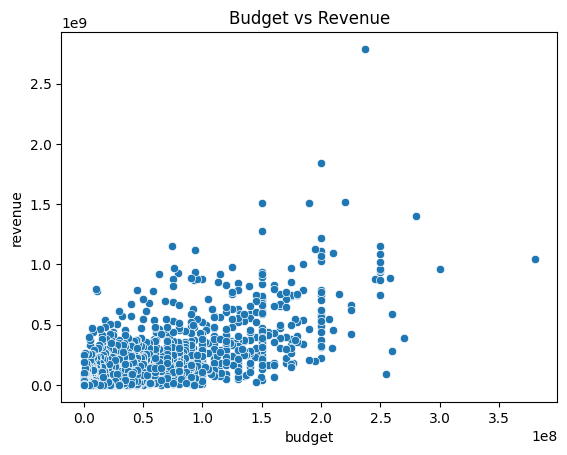

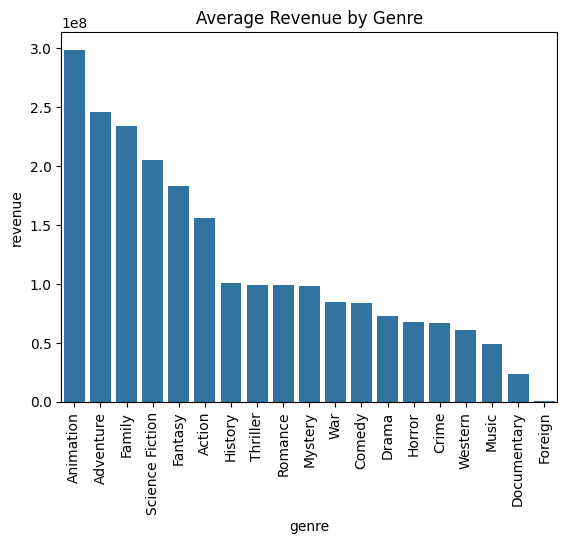

In [ ]:
sns.scatterplot(x='budget', y='revenue', data=df)
plt.title('Budget vs Revenue')
plt.show()

sns.barplot(x='genre', y='revenue', data=df.groupby('genre', as_index=False)['revenue'].mean().sort_values('revenue', ascending=False))
plt.xticks(rotation=90)
plt.title('Average Revenue by Genre')
plt.show()


In [ ]:
df['log_budget'] = np.log1p(df['budget'])
df['log_revenue'] = np.log1p(df['revenue'])
df['log_popularity'] = np.log1p(df['popularity'])

X = df[['log_budget','log_popularity','runtime','vote_average','vote_count','genre','original_language']]
y = df['log_revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
numeric_features = ['log_budget','log_popularity','runtime','vote_average','vote_count']
categorical_features = ['genre','original_language']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['log_budget',
                                                   'log_popularity', 'runtime',
                                                   'vote_average',
                                                   'vote_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['genre',
                                                   'original_language'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [ ]:
r2 = r2_score(y_test, preds)
mae = mean_absolute_error(y_test, preds)

# Some older sklearn versions don’t support squared=False, so do it manually:
mse = mean_squared_error(y_test, preds)
rmse = mse ** 0.5  # square root of MSE

print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")



R²: 0.487
MAE: 0.864
RMSE: 1.450


In [ ]:
joblib.dump(model, '/content/movie_revenue_model.joblib')


['/content/movie_revenue_model.joblib']

In [3]:
df['predicted_log_revenue'] = model.predict(X)
df['predicted_revenue'] = np.expm1(df['predicted_log_revenue'])
df.to_csv('/content/movie_predictions.csv', index=False)


NameError: name 'model' is not defined

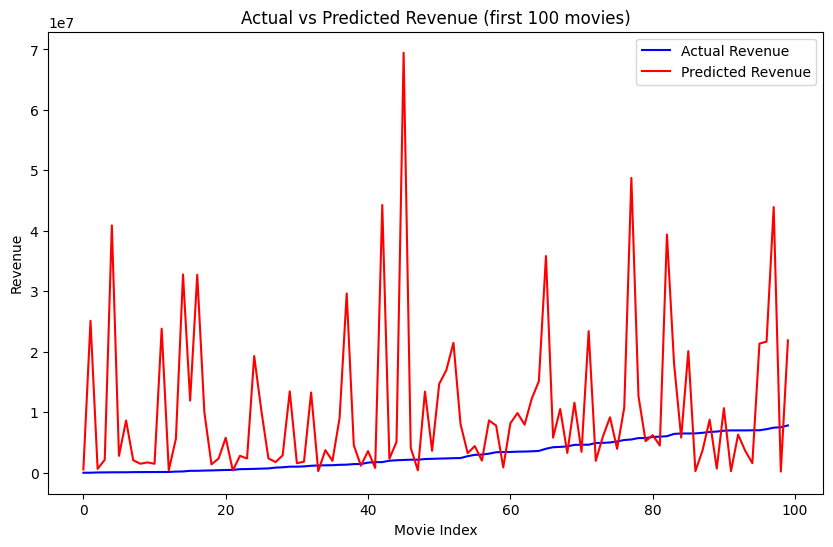

In [ ]:
# Convert log values back to normal scale for easier interpretation
y_test_actual = np.expm1(y_test)        # actual revenue
y_pred_actual = np.expm1(preds)         # predicted revenue

# Combine into a dataframe for comparison
results = pd.DataFrame({
    'Actual Revenue': y_test_actual,
    'Predicted Revenue': y_pred_actual
})

# Sort by actual revenue (optional)
results = results.sort_values('Actual Revenue').reset_index(drop=True)

# Plot comparison
plt.figure(figsize=(10,6))
plt.plot(results['Actual Revenue'].values[:100], label='Actual Revenue', color='blue')
plt.plot(results['Predicted Revenue'].values[:100], label='Predicted Revenue', color='red')
plt.title('Actual vs Predicted Revenue (first 100 movies)')
plt.xlabel('Movie Index')
plt.ylabel('Revenue')
plt.legend()
plt.show()


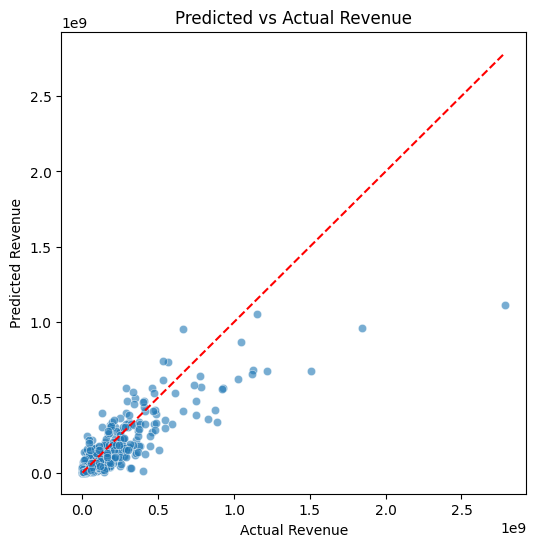

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.6)
plt.title('Predicted vs Actual Revenue')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], 'r--')  # perfect line
plt.show()


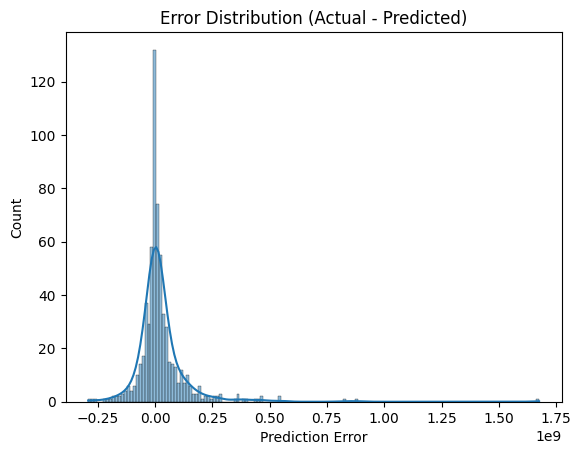

In [ ]:
errors = y_test_actual - y_pred_actual
sns.histplot(errors, kde=True)
plt.title('Error Distribution (Actual - Predicted)')
plt.xlabel('Prediction Error')
plt.show()
